# 1D-CNNタスク

241024  
- モデルの作成とdataloaderは終了
- データを秒数ごと二圧縮する処理を作ろう。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## データ前処理

In [2]:
bidet_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed_Bidet.MYD.csv', sep=',')
bidet_df.columns = ['Time', 'bidet_flow']

# dishwasher_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed_Dishwasher30.MYD.csv', sep='\\s+')
# dishwasher_df.columns = ['Time', 'dishwasher_flow', 'dishwasher_endtime']

kitchenfaucet_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed_Kitchenfaucet.MYD.csv', sep=',')
kitchenfaucet_df.columns = ['Time', 'kitchenfaucet_flow']

shower_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed_Shower.MYD.csv', sep='\\s+',header=None)
shower_df.columns = ['Time', 'shower_flow']
# display(shower_df.head())

washbasin_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed_Washbasin.MYD.csv', sep='\\s+', header=None)
washbasin_df.columns = ['Time', 'washbasin_flow']
# display(washbasin_df.head())

# washingmachine_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed_Washingmachine.MYD.csv', sep='\\s+', header=None)
# washingmachine_df.columns = ['Time', 'washingmachine_low']
# # display(washingmachine_df.head())

# wholehouse_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed_WholeHouse.MYD.csv', sep='\\s+', header=None)
# wholehouse_df.columns = ['Time', 'wholehouse_flow']
# # display(wholehouse_df.head())

# toilet_df = pd.read_csv('/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/WEUSEDTO-Data/Dataset/feed.Toilet.csv', sep='\\s+')
# toilet_df.columns = ['Time', 'toilet_flow', 'toilet_endtime']
# # display(toilet_df.head())

In [3]:
# Time列を基準にデータフレームをマージ
merged_df = bidet_df.merge(kitchenfaucet_df, on='Time', how='outer') \
                    .merge(shower_df, on='Time', how='outer') \
                    .merge(washbasin_df, on='Time', how='outer') \

# マージしたデータフレームを表示
display(merged_df.head(10))

merged_df = merged_df.iloc[1:, :] #最初の秒数0のデータはエラー？なので削除
starttime = merged_df.iloc[0,0] # 開始時間を取得
merged_df['Time'] -= starttime # 開始時間を引いて経過時間とする。

,Time,bidet_flow,kitchenfaucet_flow,shower_flow,washbasin_flow
0,0,NaN,NaN,NaN,0.0
1,1550048169,NaN,NaN,NaN,0.0
2,1550048311,NaN,NaN,NaN,123.0
3,1550048312,NaN,NaN,NaN,54.0
4,1550056694,NaN,NaN,90.0,NaN
5,1550056695,NaN,NaN,139.0,NaN
6,1550056697,NaN,NaN,65.0,NaN
7,1550056698,NaN,NaN,2.0,NaN
8,1550056700,NaN,NaN,2.0,NaN
9,1550057001,NaN,NaN,0.0,NaN


In [4]:
merged_df.fillna(0, inplace=True) # 欠損値処理
merged_df.sort_values(by='Time', ascending=True) #Timeの列を基準にsort
merged_df['gross'] = merged_df['bidet_flow'] + merged_df['kitchenfaucet_flow'] + merged_df['shower_flow'] + merged_df['washbasin_flow']

merged_df_2019 = merged_df[merged_df.Time <= 30000000].reset_index(drop=True) # 2019年データ
merged_df_2020 = merged_df[merged_df.Time >= 30000000].reset_index(drop=True) # 2020年データ


# Timeを計測開始時刻からの経過時間に変更
starttime_2019 = merged_df_2019.copy().iloc[0,0]
starttime_2020 = merged_df_2020.copy().iloc[0,0]

merged_df_2019.Time -= starttime_2019
merged_df_2020.Time -= starttime_2020

In [5]:
# 時系列をすべて作成。
max_2019 = max(merged_df_2019.Time)
sequence_2019 = np.arange(1, max_2019)
df_sequence_2019 = pd.DataFrame(sequence_2019, columns=['Time'])
merged_df_2019 = pd.merge(df_sequence_2019, merged_df_2019, on='Time', how='left').fillna(0)

max_2020 = max(merged_df_2020.Time)
sequence_2020 = np.arange(1, max_2020)
df_sequence_2020 = pd.DataFrame(sequence_2020, columns=['Time'])
merged_df_2020 = pd.merge(df_sequence_2020, merged_df_2020, on='Time', how='left').fillna(0)

In [6]:
# 時系列データを指定された秒数ごとに合計する関数
def complessed_data(df, interval):
    """
    時系列データを指定された秒数ごとに合計する関数

    Parameters:
    df (pd.DataFrame): 時系列データを含むデータフレーム
    time_column (str): 時間を示すカラム名（例: 'Time_group'）
    data_columns (list): 合計したいデータのカラム名（例: ['flow1', 'flow2']）
    interval (int): データを合計する秒数（例: 6, 10, 60）

    Returns:
    pd.DataFrame: 指定した秒数ごとにデータが合計されたデータフレーム
    """
    # Time列をintervalごとにグループ化してデータを合計
    df['Time_group'] = (df['Time'] // interval) * interval
    resampled_df = df.groupby('Time_group')[['bidet_flow', 'kitchenfaucet_flow', 'shower_flow','washbasin_flow', 'gross']].sum().reset_index()
    
    return resampled_df

# 正規化する関数（Time列以外）
def normalize_columns(df):
    # Time列以外を選択
    columns_to_normalize = df.columns.difference(['Time_group'])
    
    # MinMaxScalerを使って0-1範囲に正規化
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    
    return df

# ランダムな始点を決めて等間隔でサンプリングする関数
# def random_resample(df, interval, num_samples=600, seed=None):
#     '''
#     df: サンプリング対象のデータフレーム
#     interval: 何秒ごとにするか(本件では 6 or 10 or 60)
#     num_samples: 何個サンプリングするか(本件では基本的に600)
#     seed: ランダムサンプリングの再現性を保つためのseed
#     '''
#     # シードを固定してランダムな始点を決定
#     if seed is not None:
#         np.random.seed(seed)
    
#     # Time列の範囲内でランダムな始点を決める
#     start_time = np.random.uniform(df['Time_group'].min(), df['Time_group'].max() - (interval * (num_samples - 1)))
    
#     # print(f"ランダムな始点: {start_time}")
    
#     # ランダムな始点から interval ごとに num_samples 個の時間点を生成
#     new_time = np.arange(start_time, start_time + interval * num_samples, interval)
    
#     # Time列と補間対象のフローデータを取得
#     time_values = df['Time_group'].values
#     flows = df[['bidet_flow', 'kitchenfaucet_flow', 'shower_flow', 'washbasin_flow', 'gross']].values
    
#     # 各列に対して線形補間を実行
#     resampled_flows = griddata(time_values, flows, new_time, method='linear')
    
#     # 新しいデータフレームを作成
#     resampled_df = pd.DataFrame(resampled_flows, columns=['bidet_flow', 'kitchenfaucet_flow', 'shower_flow', 'washbasin_flow', 'gross'])
#     resampled_df['Time_group'] = new_time

#     resampled_df = normalize_columns(resampled_df)
    
#     return resampled_df


# データを訓練、検証、テストに分割する関数
def split_data(df, train_size=0.6, test_size=0.25, valid_size=0.15, seed=None):
    '''
    df: データ分割対象のデータフレーム
    train_size: 何秒ごとにするか(本件では 6 or 10 or 60)
    test_size: 何個サンプリングするか(本件では基本的に600)
    valid_size: ランダムサンプリングの再現性を保つためのseed
    '''
    # データのサイズを確認
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("train_size, valid_size, and test_size must sum to 1.0")
    
    # まず、訓練用データとテスト+検証用データに分割
    train_data, temp_data = train_test_split(df, train_size=train_size, random_state=seed)
    
    # 残りのテスト+検証用データをさらにテスト用と検証用に分割
    valid_ratio = valid_size / (valid_size + test_size)  # 残りのデータに対する検証データの割合
    valid_data, test_data = train_test_split(temp_data, train_size=valid_ratio, random_state=seed)

    train_data.sort_values(by='Time_group', inplace=True)
    test_data.sort_values(by='Time_group', inplace=True)
    valid_data.sort_values(by='Time_group', inplace=True)
    
    return train_data, test_data, valid_data


In [7]:
# データの秒数ごとの合計、正規化、train-test分割を実施。
# 2019年データを使用してみる。

data = merged_df_2020.copy()
data = complessed_data(data, 60)
# data = normalize_columns(data)
display(data.head())
train, test, valid = split_data(data, seed=10)

,Time_group,bidet_flow,kitchenfaucet_flow,shower_flow,washbasin_flow,gross
0,0,0.0,51.0,0.0,0.0,51.0
1,60,484.0,330.0,0.0,145.0,959.0
2,120,0.0,0.0,651.0,0.0,651.0
3,180,0.0,0.0,0.0,0.0,0.0
4,240,0.0,0.0,0.0,0.0,0.0


- train_test_splitの方法について
    - ランダムに分けるか、時系列性を保って分けるか

- 要相談

## 1D-CNNの実装

- これで問題なさそう？
    - 損失関数はマルチMSEとかありそう？？

- paddingについて調べる
    - padding = 2, padding = 1の妥当性。
    - 次の層の次元を揃えるために使用している。

- パディング
    - パディングの2はフィルターがデータの端で情報を失わないように、左右に2つの0を追加することを意味する。これにより入力の時系列データの長さを保持しつつ、端でも畳み込みを実行することが可能。
- バッチ
    - 機械学習や深層学習でモデルが1回のパラメータ更新(つまり1ステップの学習)で処理するサンプル数を指す。
    - バッチサイズが600説。

- L=600は、時系列のwindowサイズを表している。
- バッチサイズは4096。これは一度にモデルに入力されるサンプルデータの数。
- バッチサイズ（batch size）4096は、一度にモデルに入力されるサンプルの数を指します。各バッチには4096サンプルが含まれ、それぞれが600のフレーム長を持つ時系列データです。
- エポックが何回学習させるか。今回はearly stoppingありの50回。

### データローダーの作成
ここでは、データをCNNに流し込める形状に変形し、data loaderに代入を実施。

In [8]:
# 使用する変数の選択


In [9]:
import numpy as np

# 1. サンプルデータとして array_test (元栓データ) と equipment_data (設備データ) を使用
window_size = 600
batch_count = 4096  # バッチ数4096
required_length = window_size * batch_count  # 必要なデータの長さ

# array_test (元栓データ) と equipment_data (設備データ) (実際のデータに置き換え)
array_test = np.array(train.gross) # 元栓データ
equipment_data = np.array(train.drop(['gross', 'Time_group'], axis=1))  # 各設備の水使用量データ (4つの設備)

data_length = array_test.shape[0]

# 2. 順序通りのウィンドウ抽出関数
def extract_sequential_windows(data, window_size, batch_count):
    num_windows = len(data) // window_size  # 利用可能なウィンドウ数
    windows = np.array([data[i*window_size:(i+1)*window_size] for i in range(batch_count)])
    return windows

# 3. ランダムにウィンドウを抽出して補完する関数
def extract_random_windows(data, window_size, required_windows):
    data_length = len(data)
    windows = []
    
    for _ in range(required_windows):
        # ランダムにウィンドウの開始位置を決定
        start_index = np.random.randint(0, data_length - window_size)
        window = data[start_index:start_index + window_size]
        windows.append(window)
    
    windows = np.array(windows)
    return windows

# 4. 同じウィンドウ範囲で元栓データと設備データを抽出
def extract_synced_windows(main_data, equip_data, window_size, batch_count):
    if len(main_data) >= required_length:
        # 十分なデータがある場合は順にウィンドウを抽出
        main_windows = extract_sequential_windows(main_data, window_size, batch_count)
        equip_windows = extract_sequential_windows(equip_data, window_size, batch_count)
    else:
        # データが不足している場合は順に取りつつ、ランダムに補完
        available_windows = len(main_data) // window_size
        main_windows_seq = extract_sequential_windows(main_data, window_size, available_windows)
        equip_windows_seq = extract_sequential_windows(equip_data, window_size, available_windows)
        
        # ランダムにウィンドウを抽出して必要な数まで補完
        missing_windows = batch_count - available_windows
        main_windows_rand = extract_random_windows(main_data, window_size, missing_windows)
        equip_windows_rand = extract_random_windows(equip_data, window_size, missing_windows)
        
        # 順序通りのウィンドウとランダムなウィンドウを結合
        main_windows = np.concatenate([main_windows_seq, main_windows_rand], axis=0)
        equip_windows = np.concatenate([equip_windows_seq, equip_windows_rand], axis=0)
    
    return main_windows, equip_windows

# 5. 同期されたウィンドウを取得
main_windows, equip_windows = extract_synced_windows(array_test, equipment_data, window_size, batch_count)

# 6. チャンネル次元を追加 (main_windowsは (4096, 1, 600)、equip_windowsは (4096, 4, 600) にする)
main_windows = main_windows.reshape(batch_count, 1, window_size)
equip_windows = equip_windows.transpose(0, 2, 1)  # (4, 4096, 600) → (4096, 4, 600)

# 7. 結果の確認
print("元栓データのバッチ形状:", main_windows.shape)  # (4096, 1, 600)
print("設備データのバッチ形状:", equip_windows.shape)  # (4096, 4, 600)

# NumPy配列をPyTorchテンソルに変換
inputs_tensor = torch.tensor(main_windows, dtype=torch.float32)
targets_tensor = torch.tensor(equip_windows, dtype=torch.float32)

# TensorDatasetとDataLoaderを作成
dataset = TensorDataset(inputs_tensor, targets_tensor)
train_loader = DataLoader(dataset, batch_size=4096, shuffle=True)

# デバイス設定（GPUが使用可能か確認）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

元栓データのバッチ形状: (4096, 1, 600)
設備データのバッチ形状: (4096, 4, 600)


### 評価指標
論文中で記載の評価指標を作成

In [10]:
# EAC (Estimated Accuracy)
def eac(y_true, y_pred):
    numerator = np.sum(np.abs(y_pred - y_true))
    denominator = 2 * np.sum(y_true)
    return 1 - numerator / denominator

# NDE (Normalized Disaggregation Error)
def nde(y_true, y_pred):
    numerator = np.sum((y_pred - y_true) ** 2)
    denominator = np.sum(y_true ** 2)
    return np.sqrt(numerator / denominator)

# MAE (Mean Absolute Error)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

# 評価指標を計算する関数
def calculate_metrics(y_true, y_pred):
    eac_value = eac(y_true, y_pred)
    nde_value = nde(y_true, y_pred)
    mae_value = mae(y_true, y_pred)
    
    return eac_value, nde_value, mae_value

### 1D-CNN
論文中で記載の内容でモデルを作成

In [11]:
# 1D-CNNモデルの定義
class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_outputs):
        super(CNN1DModel, self).__init__()
        
        # 畳み込み層の定義
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        
        # Adaptive avg pooling
        self.adaptive_avg_pool = nn.AdaptiveAvgPool1d(16)
        
        # MLP層。最終的なアウトプットは600秒間の4つの設備データ
        # FC層を3層に分ける
        self.fc1 = nn.Linear(128 * 16, 1024)  # 2048次元 → 1024次元
        self.fc2 = nn.Linear(1024, 512)      # 1024次元 → 512次元
        self.fc3 = nn.Linear(512, num_outputs)  # 512次元 → 2400次元（4 * 600）

        self.relu = nn.ReLU()
        
    def forward(self, x):
        # 畳み込み層とバッチ正規化、ReLU
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        
        # Adaptive avg pooling
        x = self.adaptive_avg_pool(x)
        x = x.view(x.size(0), -1)  # フラット化 (batch_size, 128 * 16)
        
        # 全結合層
        x = self.relu(self.fc1(x))  # (batch_size, 1024)
        x = self.relu(self.fc2(x))  # (batch_size, 512)
        x = self.fc3(x)             # (batch_size, 2400)
        
        # 出力を (batch_size, 4, 600) にリシェイプ
        x = x.view(x.size(0), 4, 600)
        
        return x

# モデルのインスタンス化とデバイスへの転送
input_channels = 1
num_outputs = 4 * 600  # 出力は4設備の時系列であるため、4 * 600
model = CNN1DModel(input_channels, num_outputs).to(device)

# 損失関数と最適化手法の定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# モデルのトレーニング
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_true = []
        all_pred = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            # ロスを計算
            loss = criterion(outputs, targets)
            
            # バックプロパゲーションと最適化
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 出力とターゲットを保存（評価指標の計算のため）
            all_true.append(targets.detach().cpu().numpy())  # GPUからCPUへ移動
            all_pred.append(outputs.detach().cpu().numpy())  # GPUからCPUへ移動
        
        # すべてのバッチの予測と正解を結合
        y_true = np.concatenate(all_true, axis=0)
        y_pred = np.concatenate(all_pred, axis=0)
        
        # 評価指標を計算
        eac_value, nde_value, mae_value = calculate_metrics(y_true, y_pred)
        
        # 各エポックの結果を表示
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        print(f"EAC: {eac_value:.4f}, NDE: {nde_value:.4f}, MAE: {mae_value:.4f}")

    print(y_true.shape)
    print(y_pred.shape)

### トレーニングの実行

In [12]:
# トレーニング実行例
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 28332.6641
EAC: 0.4977, NDE: 1.0000, MAE: 8.4399
Epoch [2/10], Loss: 28331.3008
EAC: 0.4948, NDE: 1.0000, MAE: 8.4896
Epoch [3/10], Loss: 28326.3828
EAC: 0.4795, NDE: 0.9999, MAE: 8.7459
Epoch [4/10], Loss: 28313.9531
EAC: 0.4349, NDE: 0.9997, MAE: 9.4957
Epoch [5/10], Loss: 28292.1602
EAC: 0.3336, NDE: 0.9993, MAE: 11.1974
Epoch [6/10], Loss: 28269.9609
EAC: 0.1469, NDE: 0.9989, MAE: 14.3357
Epoch [7/10], Loss: 28272.0430
EAC: -0.0943, NDE: 0.9989, MAE: 18.3879
Epoch [8/10], Loss: 28256.9727
EAC: -0.0934, NDE: 0.9987, MAE: 18.3737
Epoch [9/10], Loss: 28240.0273
EAC: -0.0015, NDE: 0.9984, MAE: 16.8301
Epoch [10/10], Loss: 28234.1641
EAC: 0.0827, NDE: 0.9983, MAE: 15.4150
(4096, 4, 600)
(4096, 4, 600)


- 全体として損失出せているけど、facilityごとに出せていない。
- EACがマイナスになるのはなんで？

### 結果の可視化

/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/EL-WaterDemandTS/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/EL-WaterDemandTS/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26643 (\N{CJK UNIFIED IDEOGRAPH-6813}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/EL-WaterDemandTS/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tomokitakata/Desktop/Tarantula/Water Disaggregation/EL-WaterDemandTS/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (

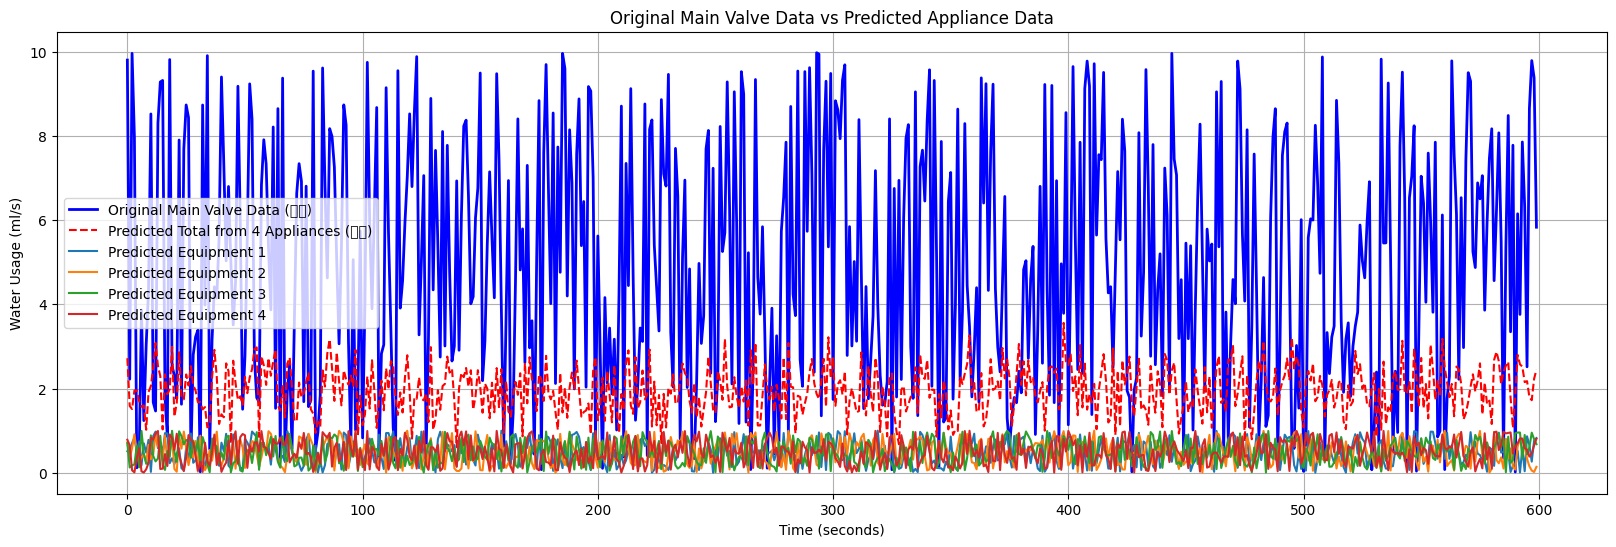

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 1. サンプルデータ: 元栓データの生成（実際にはあなたの元栓データを使ってください）
# ここでは仮にランダムな元栓データを使用しています
time_points = 600  # 600秒間
original_data = np.random.rand(time_points) * 10  # 元栓データ (仮のデータ)

# 2. 予測された4つの設備のデータ（実際にはモデルから得た出力を使用）
# ここでも仮にランダムなデータを使用しています
predicted_equipment_data = np.random.rand(4, time_points)

# 3. 4つの設備データを合計して、元栓データと比較する
predicted_total_data = np.sum(predicted_equipment_data, axis=0)

# 4. 元栓データと予測データを重ねてプロット
plt.figure(figsize=(20, 6))

plt.plot(original_data, label="Original Main Valve Data (元栓)", color='b', linewidth=2)
plt.plot(predicted_total_data, label="Predicted Total from 4 Appliances (予測)", color='r', linestyle='--')

# 予測された各設備のデータをプロット
for i in range(4):
    plt.plot(predicted_equipment_data[i], label=f"Predicted Equipment {i+1}")

# グラフの設定
plt.xlabel("Time (seconds)")
plt.ylabel("Water Usage (ml/s)")
plt.title("Original Main Valve Data vs Predicted Appliance Data")
plt.legend()
plt.grid(True)

# 可視化
plt.show()